In [34]:
from gaussian_model import CenteredGM
import tqdm
import numpy as np
import torch as tch
import matplotlib.pyplot as plt
from scipy.optimize import brentq
%matplotlib inline
from experiment_manager.explorer import get_siblings
import json
from tqdm import tqdm


def j_map(c_emp, alpha, gamma, mu=1.):
    return (alpha*c_emp + gamma*mu - np.sqrt((alpha*c_emp - gamma*mu)**2 + 4 * alpha * gamma)) / (2. * gamma)

def j_large_gamma(c, alpha, gamma, mu=1.):
    return (c-1./mu)*alpha / gamma

def j_small_gamma(c, alpha, gamma, mu=1.):
    return mu - 1/c + gamma / alpha * (1/(c**3)-mu/(c**2))




1e-12


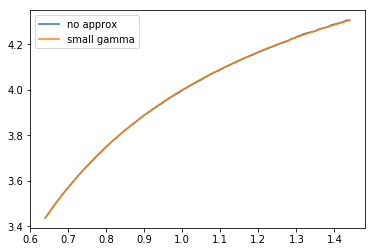

1e-08


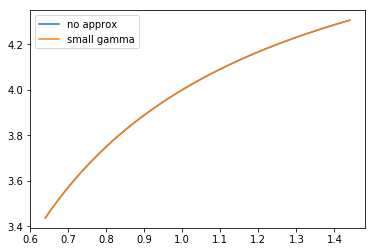

1e-05


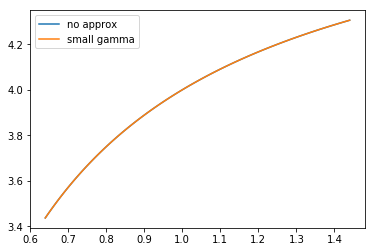

0.01


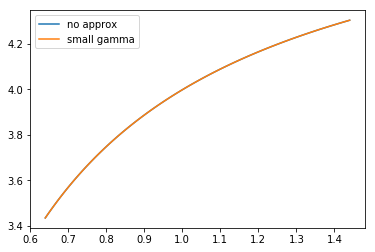

0.1


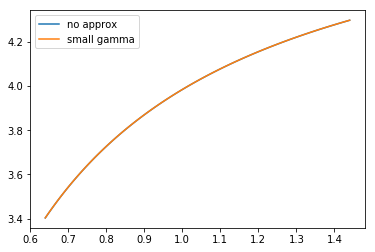

In [39]:
def plots_small():
    alpha = 25.
    mu_ = 5
    gammas = [1e-12, 1e-8, 1e-5, 1e-2, 1e-1]
    points = np.linspace((1-1./np.sqrt(alpha))**2, (1+1./np.sqrt(alpha))**2, 100)
    
    for gamma in gammas:
        print(gamma)
        j = lambda c : j_map(c, alpha, gamma, mu=mu_)
        j_large = lambda c : j_large_gamma(c, alpha, gamma, mu=mu_)
        j_small = lambda c : j_small_gamma(c, alpha, gamma, mu=mu_)
        
        plt.figure()
        plt.plot(points, j(points), label='no approx')
        plt.plot(points, j_small(points), label='small gamma')
        plt.legend()
        plt.show()

plots_small()


Our J_map fits the small gamma expansion for all mus and all alpha when gamma is smaller than 10^-2 on the whole set of Wishart possible eigenvalues.

1.0


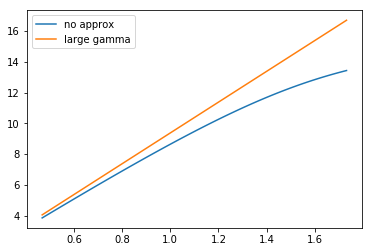

10.0


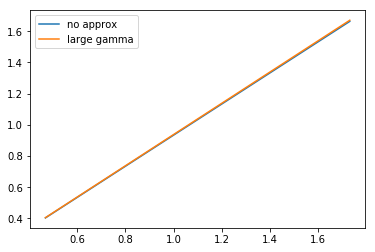

30.0


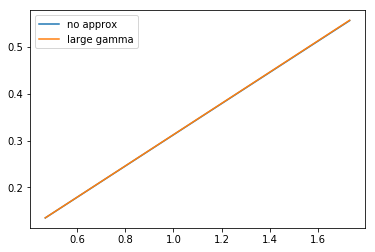

10000.0


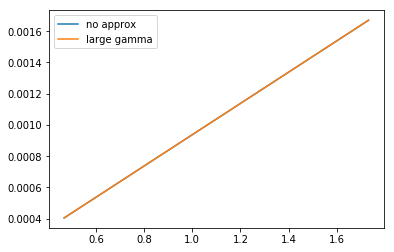

100000.0


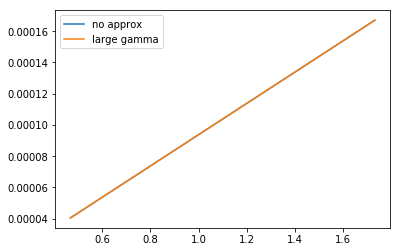

In [43]:
def plots_large():
    alpha = 10
    mu_ = 16
    gammas = [1e0, 1e1, 3e1, 1e4, 1e5]
    points = np.linspace((1-1./np.sqrt(alpha))**2, (1+1./np.sqrt(alpha))**2, 100)
    
    for gamma in gammas:
        print(gamma)
        j = lambda c : j_map(c, alpha, gamma, mu=mu_)
        j_large = lambda c : j_large_gamma(c, alpha, gamma, mu=mu_)
        j_small = lambda c : j_small_gamma(c, alpha, gamma, mu=mu_)
        
        plt.figure()
        plt.plot(points, j(points), label='no approx')
        plt.plot(points, j_large(points), label='large gamma')
        plt.legend()
        plt.show()

plots_large()

Same as before, around 10 the curve starts to be exactly superposed to its large gamma expansion.
Now, try integration : maybe out integrator is shitty

In [71]:
N = 50
sigma = np.zeros((N, N))
model_to_fit = CenteredGM(N, precision=sigma, silent=True)

def rho_averaging(f, alpha, gaussian_model, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(f(spectrum.cpu().numpy()))
    return np.mean(acc)

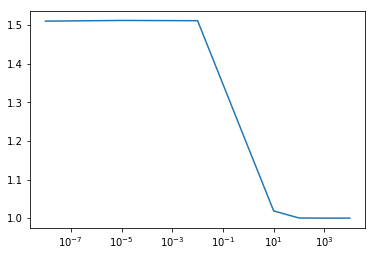

[1.510768366598624,
 1.5126008436117784,
 1.5119322805782642,
 1.1826049188178984,
 1.0186366862268181,
 1.000306809790168,
 1.0000065267317368,
 1.0000000539888034]

In [90]:
def solve_mu(gaussian_model, alpha, gamma, n_samples=1e4, _debug=True):
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    # Because of the theoretical formula, we know that the mu normalization integral varies in 
    # 1 pm gamma / alpha -> impossible to solve numerically, too much uncertainty
    if gamma / alpha < 1e-2:
        return avg(lambda c: 1./c)
    
    mu_min = 0.98
    mu_max = rho_averaging(lambda C: 1./C, alpha, gaussian_model) 
    j_star = lambda C, mu: j_map(C, alpha, gamma, mu=mu)
    
    def surrogate(mu):
        plop = lambda C: 1. / (mu - j_star(C, mu))
        return 1. - avg(plop)
    
    # This to avoid issues when gamma too large, mu gets too close to 1
    if gamma / alpha > 1e2:
        try :
            roots = brentq(surrogate, mu_min, mu_max)
        except ValueError:
            return 1.
        
    # Regular pathways
    else :
        roots = brentq(surrogate, mu_min, mu_max)
    
    return roots

def plot_mu_gamma(gaussian_model, alpha, gamma_range, n_samples=1e4):
    mus = []
    for gamma in tqdm(gamma_range, leave=False):
        mus.append(solve_mu(gaussian_model, alpha, gamma))
    plt.figure()
    plt.semilogx(gamma_range, mus)
    plt.show()
    return mus

plot_mu_gamma(model_to_fit, 3., [1e-8, 1e-5, 1e-2, 1, 10, 100, 1000, 10000])

In [ ]:
def averaging_small():
    alpha = 3.
    mus = np.linspace(1., alpha/(alpha-1.) + 1., 5)
    gammas = [1e-5, 1e-3, 1e-1, 1.]
    inv = lambda c: 1./ c   
    
    for gamma in gammas:
        print(gamma)
        out_noapp = []
        out_app = []
        
        pop_noapp = []
        pop_app = []
        
        app_2 = []
        for mu_ in mus:
            avg = lambda func: rho_averaging(func, alpha, model_to_fit, n_samples=1e5)  
            j = lambda c: j_map(c, alpha, gamma, mu=mu_)
            plop_noapp = lambda c: 1. / (mu_ - j(c))
            
            j_small = lambda c: j_small_gamma(c, alpha, gamma, mu=mu_) 
            plop_small =  lambda c: 1. / (mu_ - j_small(c))
            
            out_noapp.append(avg(j))
            out_app.append(avg(j_small))
            
            pop_noapp.append(avg(plop_noapp)-1)
            pop_app.append(avg(plop_small)-1)

        plt.figure()

        plt.plot(mus, out_noapp, label='no approx')
        plt.plot(mus, out_app, label='small gamma')
        plt.legend()
        plt.show()
        
        plt.figure()

        plt.plot(mus, pop_noapp, label='no approx')
        plt.plot(mus, pop_app, label='small gamma')
        plt.plot(mus, gamma / alpha * (avg(inv) - mus), label='Double approx')
        plt.legend()
        plt.show()
        

        print('Mu expected to be at : {} (no app) or {} (using small gamma exp) '.format(*solve_mu_small(model_to_fit, alpha, gamma)))
        
averaging_small()

# Once again, the averages seems to be fairly same across the board : if gamma < 1e-2, shit goes well
# However, for small gamma we have 1 - integral((mu-J)-1) of order gamma : too much uncertainty to compute

# This suggests to hardcode the gamma < 10-2 case

0.1


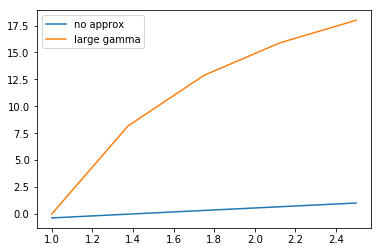

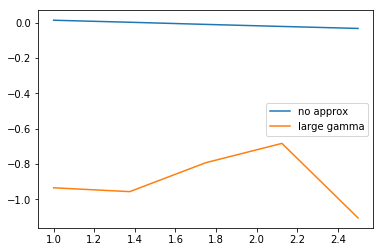

0.9 2.5163602032986763
1.9184973511532486
Mu expected to be at : 1.4152264410804485 (no app) or 1.9184973511532486 (using small gamma exp) 
0.5


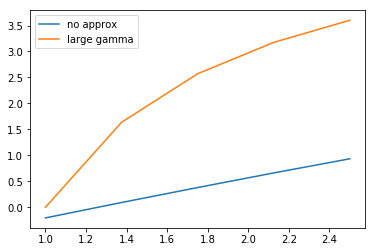

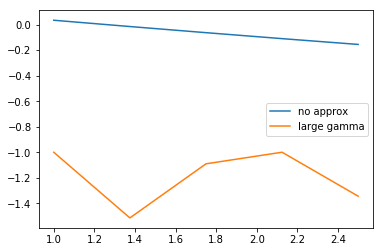

0.9 2.512508828585392
1.156605936263204
Mu expected to be at : 1.2612554234635882 (no app) or 1.156605936263204 (using small gamma exp) 
2.0


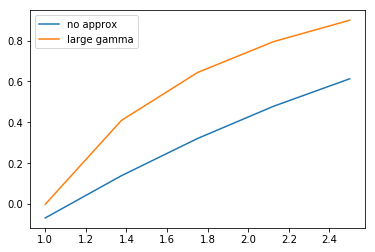

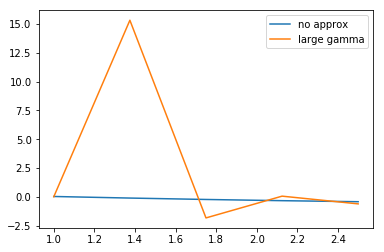

0.9 2.5129941942659877


ValueError: f(a) and f(b) must have different signs

In [87]:
def averaging_large():
    alpha = 3.
    mus = np.linspace(1., alpha/(alpha-1.) + 1., 5)
    gammas = [1e-1, 5e-1, 2., 8.]
    inv = lambda c: 1./ c   
    
    for gamma in gammas:
        print(gamma)
        out_noapp = []
        out_app = []
        
        pop_noapp = []
        pop_app = []
        
        app_2 = []
        for mu_ in mus:
            avg = lambda func: rho_averaging(func, alpha, model_to_fit, n_samples=1e5)  
            j = lambda c: j_map(c, alpha, gamma, mu=mu_)
            plop_noapp = lambda c: 1. / (mu_ - j(c))
            
            j_large = lambda c : j_large_gamma(c, alpha, gamma, mu=mu_)
            plop_large =  lambda c: 1. / (mu_ - j_large(c))
            
            out_noapp.append(avg(j))
            out_app.append(avg(j_large))
            
            pop_noapp.append(avg(plop_noapp)-1)
            pop_app.append(avg(plop_large)-1)

        plt.figure()

        plt.plot(mus, out_noapp, label='no approx')
        plt.plot(mus, out_app, label='large gamma')
        plt.legend()
        plt.show()
        
        plt.figure()

        plt.plot(mus, pop_noapp, label='no approx')
        plt.plot(mus, pop_app, label='large gamma')

        plt.legend()
        plt.show()
        

        print('Mu expected to be at : {} (no app) or {} (using small gamma exp) '.format(*solve_mu_small(model_to_fit, alpha, gamma)))
        
averaging_large()

# Conclusions :

- solve_mu will inevitably fail if gamma / alpha is small -> hardcode this part of the solution
-